In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/anabolic-steroids-dataset/anabolic_steroids.csv


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df = pd.read_csv('/kaggle/input/anabolic-steroids-dataset/anabolic_steroids.csv')
df.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Original Name,Common Name,Medicinal Use,Abused For,Side Effects,History,Relative Molecular Mass (g/mol)
0,"Testosterone,Testoviron,Hormone replacement th...",Unknown,Unknown,Unknown,Unknown,Unknown,NaN
1,"Methandrostenolone,Dianabol,None (discontinued...",Unknown,Unknown,Unknown,Unknown,Unknown,NaN
2,"Nandrolone,Deca-Durabolin,Treating anemia and ...",Unknown,Unknown,Unknown,Unknown,Unknown,NaN
3,"Oxandrolone,Anavar,Weight gain after surgery o...",Unknown,Unknown,Unknown,Unknown,Unknown,NaN
4,"Stanozolol,Winstrol,Angioedema treatment,Lean ...",Unknown,Unknown,Unknown,Unknown,Unknown,NaN


In [5]:
df.info()
df.describe()
df.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 7 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Original Name                    48 non-null     object 
 1   Common Name                      48 non-null     object 
 2   Medicinal Use                    48 non-null     object 
 3   Abused For                       48 non-null     object 
 4   Side Effects                     48 non-null     object 
 5   History                          48 non-null     object 
 6   Relative Molecular Mass (g/mol)  38 non-null     float64
dtypes: float64(1), object(6)
memory usage: 2.8+ KB


Index(['Original Name', 'Common Name', 'Medicinal Use', 'Abused For',
       'Side Effects', 'History', 'Relative Molecular Mass (g/mol)'],
      dtype='object')

In [6]:
import re 

def clean_column(col):
    return re.sub(r'[^a-zA-Z0-9]', '', col).strip().lower().replace(' ', '_')

df.columns = [clean_column(col) for col in df.columns]
df.columns

Index(['originalname', 'commonname', 'medicinaluse', 'abusedfor',
       'sideeffects', 'history', 'relativemolecularmassgmol'],
      dtype='object')

In [7]:
df.rename(columns={
    'originalname': 'original_name',
    'commonname': 'common_name',
    'medicinaluse': 'medicinal_use',
    'abusedfor': 'abused_for',
    'sideeffects': 'side_effects'
}, inplace=True)

In [8]:
df.rename(columns={'relativemolecularmassgmol': 'relative_molecular_mass_gmol'}, inplace=True)


In [9]:
df.isnull().sum()

original_name                    0
common_name                      0
medicinal_use                    0
abused_for                       0
side_effects                     0
history                          0
relative_molecular_mass_gmol    10
dtype: int64

In [10]:
df['abused_for'].value_counts()

abused_for
Performance enhancement       17
Unknown                       10
Lean muscle retention          4
Strength gains                 2
Muscle growth                  2
Bulking and cutting            2
Rapid weight gain              1
Muscle mass, strength          1
Aggression boost               1
Rarely abused                  1
Muscle growth, performance     1
Muscle hardening               1
Lean muscle gain               1
Rapid muscle growth            1
Muscle swelling                1
Bulking                        1
Cutting cycles                 1
Name: count, dtype: int64

In [11]:
def simplify_abuse_reason(reason):
    if pd.isnull(reason):
        return 'Unknown'
    reason = reason.lower()
    if 'performance' in reason: 
        return 'Performance Enhancement'
    elif 'muscle' in reason:
        return 'Muscle Growth'
    elif 'strength' in reason: 
        return 'Strength Gain'
    elif 'bulking' in reason or 'cutting' in reason:
        return 'Bulking/Cutting'
    elif 'weight' in reason:
        return 'Weight Gain'
    elif 'aggression' in reason: 
        return 'Aggression boost'
    elif 'unknown' in reason: 
        return 'Unknown'
    else:
        return 'Other'

df['abuse_reason_simplified'] = df['abused_for'].apply(simplify_abuse_reason)

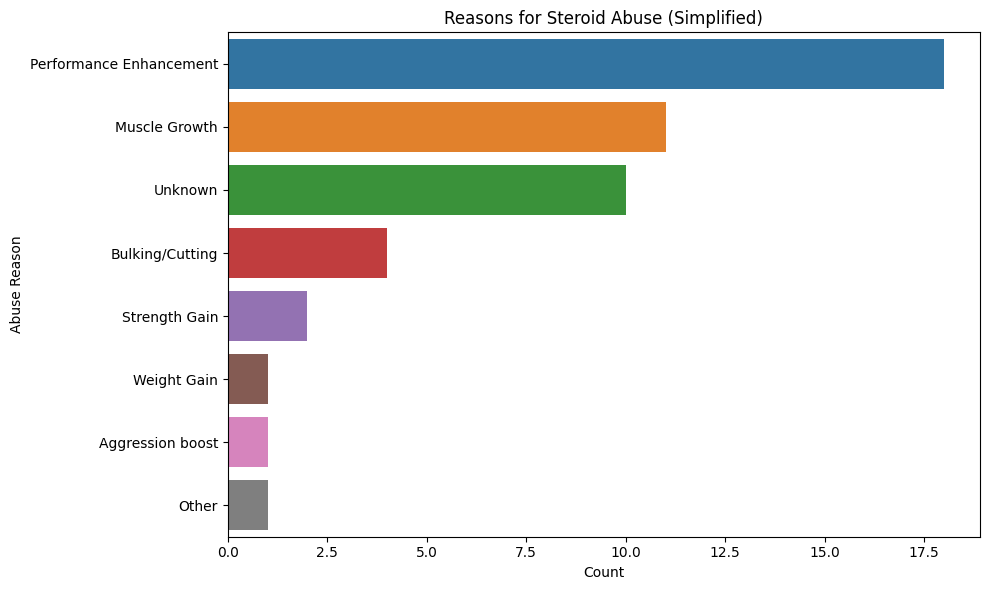

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.countplot(data=df, y='abuse_reason_simplified', order=df['abuse_reason_simplified'].value_counts().index)
plt.title("Reasons for Steroid Abuse (Simplified)")
plt.xlabel("Count")
plt.ylabel("Abuse Reason")
plt.tight_layout()
plt.show()

In [13]:
df['history'].sample(5).values

array(['Synthetic derivative of nandrolone',
       'Oral version of DHT derivative; used for therapeutic purposes',
       'Approved in the 1950s; known for potent anabolic effects',
       'Introduced in the 1950s; known for high androgenic effects',
       'Synthetic derivative of nandrolone'], dtype=object)

In [14]:
def tag_era(history_text):
    if pd.isnull(history_text) or 'unknown' in history_text.lower():
        return 'Unknown'
    elif '2000' in history_text or '2000s' in history_text:
        return '2000s'
    elif '199' in history_text:
        return '1990s'
    elif '198' in history_text:
        return '1980s'
    elif '197' in history_text:
        return '1970s'
    elif '196' in history_text:
        return '1960s'
    elif '195' in history_text:
        return '1950s'
    else:
        return 'Other'

df['era'] = df['history'].apply(tag_era)

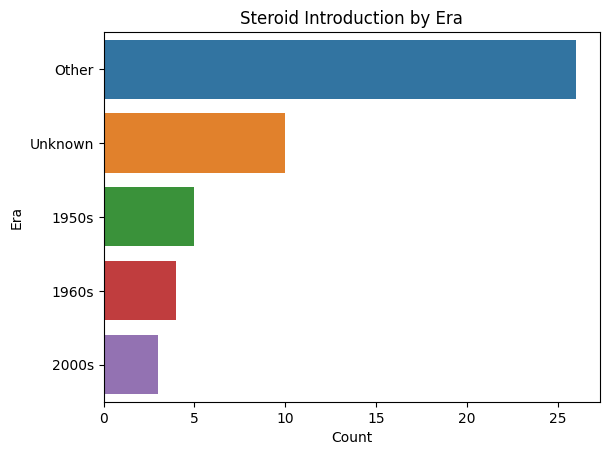

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=df, y='era', order=df['era'].value_counts().index)
plt.title("Steroid Introduction by Era")
plt.xlabel("Count")
plt.ylabel("Era")
plt.show()

In [16]:
df[df['history'].str.contains('balco', case=False, na=False)]

,original_name,common_name,medicinal_use,abused_for,side_effects,history,relative_molecular_mass_gmol,abuse_reason_simplified,era
34,Tetrahydrogestrinone,THG,Unknown,Performance enhancement,Severe liver damage,Designer steroid exposed during the BALCO scandal,312.45,Performance Enhancement,Other


In [17]:
pd.crosstab(df['era'], df['abuse_reason_simplified'])

abuse_reason_simplified,Aggression boost,Bulking/Cutting,Muscle Growth,Other,Performance Enhancement,Strength Gain,Unknown,Weight Gain
era,,,,,,,,
1950s,0,0,0,0,2,2,0,1
1960s,0,2,2,0,0,0,0,0
2000s,0,0,1,0,2,0,0,0
Other,1,2,8,1,14,0,0,0
Unknown,0,0,0,0,0,0,10,0


In [24]:
print(df.columns.tolist())

['original_name', 'common_name', 'medicinal_use', 'abused_for', 'side_effects', 'history', 'relative_molecular_mass_gmol', 'abuse_reason_simplified', 'era', 'aggression', 'liver', 'hair', 'acne', 'cardio', 'abuse_group']


In [22]:
def simplify_abuse(reason):
    if pd.isnull(reason):
        return 'Unknown'
    reason = reason.lower()
    if 'performance' in reason:
        return 'Performance'
    elif 'muscle' in reason or 'mass' in reason:
        return 'Muscle Gain'
    elif 'cutting' in reason or 'lean' in reason:
        return 'Cutting'
    elif 'weight' in reason or 'bulking' in reason:
        return 'Bulking'
    else:
        return 'Other'

df['abuse_group'] = df['abused_for'].apply(simplify_abuse)

In [27]:
symptoms = ['aggression', 'liver', 'hair', 'acne', 'cardio']

for s in symptoms:
    df[s] = df['side_effects'].str.contains(s, case=False, na=False)

summary = {}
for s in symptoms:
    summary[s] = df.groupby('abuse_group')[s].mean() * 100  # percent with that symptom

table = pd.DataFrame(summary).round(1)

table.style.set_caption("Prevalence of Side Effects by Abuse Category (%)") \
     .background_gradient(cmap='Oranges')

,aggression,liver,hair,acne,cardio
abuse_group,,,,,
Bulking,0.000000,50.000000,0.000000,0.000000,0.000000
Cutting,66.700000,33.300000,0.000000,0.000000,0.000000
Muscle Gain,9.100000,72.700000,18.200000,18.200000,18.200000
Other,7.100000,21.400000,7.100000,0.000000,14.300000
Performance,5.600000,16.700000,5.600000,27.800000,0.000000
